AiApp Miniproject; Leonie Däullary, Ruwen Frick

Needed packages

In [9]:
pip install opendatasets tensorflow matplotlib scipy numpy tabulate sklearn

Imports

In [10]:
import tensorflow as tf

from keras_preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D
from keras.layers import Flatten, Dense, MaxPooling2D

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import opendatasets as od
import os
from pathlib import Path

from numpy import argmax
from tabulate import tabulate
from sklearn.metrics import accuracy_score

Dowloading the data

The dataset is hosted on Kaggle. When executing the following cell you will be asked for your Kaggle credentials. These can be acquired by following below steps:

1. Sign in to https://kaggle.com/ or register a new account, then click on your profile picture on the top right and select "My Account" from the menu.

2. Scroll down to the "API" section and click "Create New API Token". This will download a file kaggle.json with the following contents:
    {"username":"YOUR_KAGGLE_USERNAME","key":"YOUR_KAGGLE_KEY"}

In [29]:
dataset_url = 'https://www.kaggle.com/sachinkumar413/alzheimer-mri-dataset'
od.download(dataset_url)

path = Path(".", 'alzheimer-mri-dataset', 'Dataset').absolute()

print(f"Data stored at: {path}")

mild_path = Path(path, 'Mild_Demented')
moderate_path = Path(path, 'Moderate_Demented')
non_path = Path(path, 'Non_Demented')
very_mild_path = Path(path, 'Very_Mild_Demented')


classes = [dir for dir in sorted(os.listdir(path))]


Skipping, found downloaded files in ".\alzheimer-mri-dataset" (use force=True to force download)
Data stored at: c:\Users\leoni\OneDrive\Dokumente\HSR\6. Semester\02_Ai-Applications\04_Sonstiges\covid-detection\code\alzheimer-mri-dataset\Dataset


Print some examples of the train set

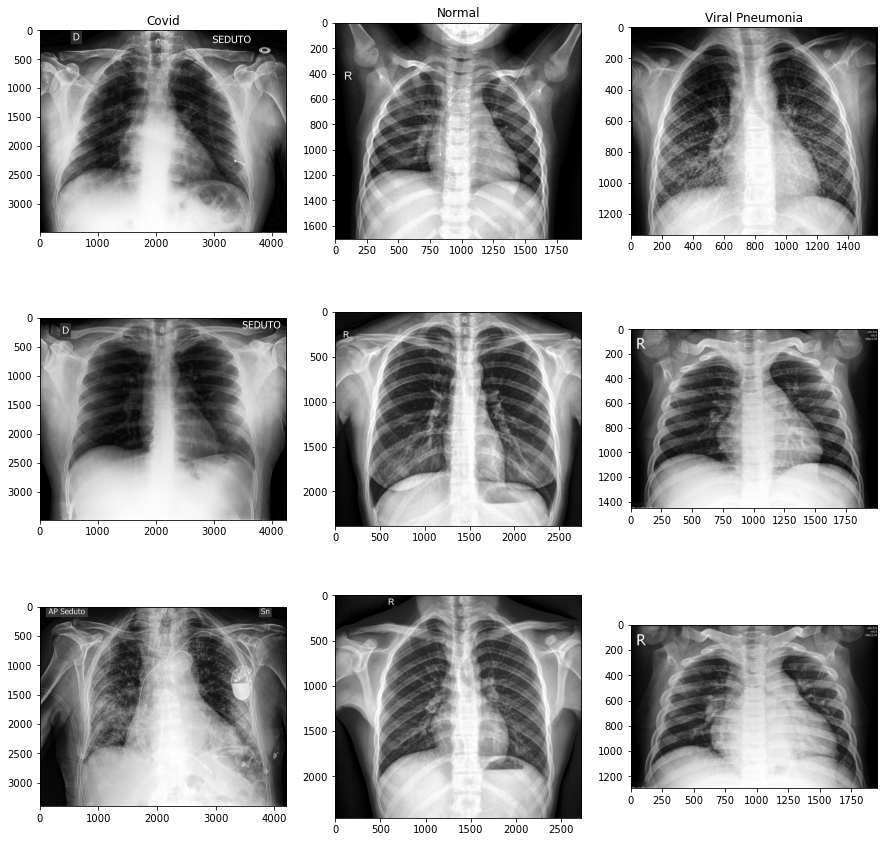

In [14]:
covid_imgs = []
normal_imgs = []
pneumonia_imgs = []

for i in range(1, 4):
    covid_imgs.append(mpimg.imread(Path(train_path, classes[0], '0' + str(i) + '.jpeg')))
    normal_imgs.append(mpimg.imread(Path(train_path, classes[1], '0' + str(i) + '.jpeg'))) 
    pneumonia_imgs.append(mpimg.imread(Path(train_path, classes[2], '0' + str(i) + '.jpeg')))

plt.figure(figsize = (15, 15))

# First row
plt.subplot(3, 3, 1)
plt.imshow(covid_imgs[0])
plt.title('Covid')
plt.subplot(3, 3, 2)
plt.imshow(normal_imgs[0])
plt.title('Normal')
plt.subplot(3, 3, 3)
plt.imshow(pneumonia_imgs[0])
plt.title('Viral Pneumonia')

# Second row
plt.subplot(3, 3, 4)
plt.imshow(covid_imgs[1])
plt.subplot(3, 3, 5)
plt.imshow(normal_imgs[1])
plt.subplot(3, 3, 6)
plt.imshow(pneumonia_imgs[1])

# Third row
plt.subplot(3, 3, 7)
plt.imshow(covid_imgs[2])
plt.subplot(3, 3, 8)
plt.imshow(normal_imgs[2])
plt.subplot(3, 3, 9)
plt.imshow(pneumonia_imgs[2])

plt.show()

Preprocessing and Data Augmentation

In [34]:
# Data generation parameters
image_size = (128, 128)
horizontal_flip = True
color_mode = 'grayscale'
zoom_range = 0.05
rotation_range = 25
shear_range = 0.2
batch_size  = 32
validation_split = 0.2



train_valid_data_generator = ImageDataGenerator(
    horizontal_flip = horizontal_flip,
    zoom_range = zoom_range,
    rotation_range = rotation_range,
    shear_range = shear_range,
    validation_split = validation_split
)

train_data = train_valid_data_generator.flow_from_directory(
    path,
    target_size = image_size,
    color_mode = color_mode,
    batch_size  = batch_size,
    subset = 'training'
)

valid_data = train_valid_data_generator.flow_from_directory(
    path,
    target_size = image_size,
    color_mode = color_mode,
    batch_size  = batch_size,
    subset = 'validation'
)

test_data = ImageDataGenerator.flow_from_directory(
    path
)

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


Building the model

In [39]:
# Parameters for first set of layers
num_filters_1 = 32
kernel_size_1 = (2,2)
pool_size_1 = (2, 2)
activation_1 = 'relu'

# Parameters for second set of layers
num_filters_2 = 64
kernel_size_2 = 3
pool_size_2 = (2, 2)
activation_2 = 'relu'

# Parameters for third set of layers
num_filters_3 = 64
kernel_size_3 = 3
pool_size_3 = (2, 2)
activation_3 = 'relu'

model = tf.keras.Sequential([
  Conv2D(num_filters_1, kernel_size_1, activation = activation_1, input_shape = (128, 128, 1)),
  MaxPooling2D(pool_size = pool_size_1),
  Conv2D(num_filters_2, kernel_size_2, activation = activation_2),
  MaxPooling2D(pool_size = pool_size_2),
  Conv2D(num_filters_3, kernel_size_3, activation = activation_3),
  MaxPooling2D(pool_size = pool_size_3),
  Flatten(),
  Dense(64, activation='relu'),
  Dense(len(classes), activation='softmax'),
])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 127, 127, 32)      160       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 64)      

Compile and fit model

In [40]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])


In [41]:
history = model.fit(
    train_data,
    epochs = 5,
    validation_data = valid_data,
)

Epoch 1/5
161/161 [==============================] - 133s 815ms/step - loss: 3.6148 - accuracy: 0.4983 - val_loss: 1.0671 - val_accuracy: 0.4574
Epoch 2/5
 19/161 [==>...........................] - ETA: 52s - loss: 0.9506 - accuracy: 0.5691

Print statistics

In [25]:
# predict test data
predicted_classes = argmax(model.predict(test_data), axis = 1)

Test Accuracy: 0.3333333333333333
True Class       Predicted Class
---------------  -----------------
Covid            Covid
Covid            Viral Pneumonia
Covid            Viral Pneumonia
Covid            Viral Pneumonia
Covid            Viral Pneumonia
Covid            Viral Pneumonia
Covid            Covid
Covid            Viral Pneumonia
Covid            Viral Pneumonia
Covid            Viral Pneumonia
Covid            Covid
Covid            Viral Pneumonia
Covid            Covid
Covid            Viral Pneumonia
Covid            Covid
Covid            Viral Pneumonia
Covid            Covid
Covid            Viral Pneumonia
Covid            Viral Pneumonia
Covid            Viral Pneumonia
Covid            Covid
Covid            Viral Pneumonia
Covid            Covid
Covid            Viral Pneumonia
Covid            Viral Pneumonia
Covid            Viral Pneumonia
Normal           Viral Pneumonia
Normal           Covid
Normal           Covid
Normal           Covid
Normal           V

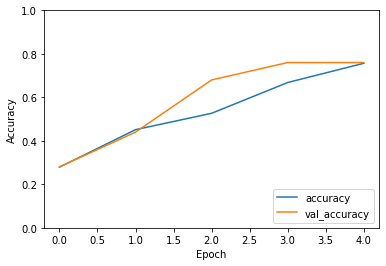

In [26]:
# print accuracy
accuracy = accuracy_score(predicted_classes, test_data.classes)
print(f'Test Accuracy: {accuracy}')

# print true and predicted class
to_print = []
for true, predicted in zip(test_data.classes, predicted_classes):
    to_print.append([classes[true], classes[predicted]])

print(tabulate(to_print, headers = ['True Class', 'Predicted Class']))

# plot accuracy against epochs
plt.plot(history.history['accuracy'], label= 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend(loc='lower right')
